# 状态图

在上一节中，我们演示了如何使用 LangGraph 创建 ReAct Agent。但是，把任务交给 Agent 等于把控制权也交了出去。如果你不希望 Agent 拥有如此高的控制权，而是希望流程完全受你控制，那么你可以使用 **状态图**（StateGraph）来创建工作流。

In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.runnables import RunnableConfig

# 加载模型配置
_ = load_dotenv()
print('done')

done


本节实现了一个简单的工作流。该工作流接入一个可查询天气的工具。区别于 ReAct Agent 可以自主实现工具调用，这里我们通过“条件边”，手动编写工具的触发逻辑。

为了实现这一目标，我们需要先创建三样东西：

- **助手节点**：装载了 LLM，用于判断是否需要调用工具
- **工具节点**：一个可获取城市天气的工具。这里被我们简化，对任何城市均输出晴天
- **条件边**：连接助手节点与工具节点。根据助手节点的输出，决定是否调用工具

In [2]:
# 加载模型
llm = ChatOpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
    model="qwen3-coder-plus",
    temperature=0.7,
)

# 工具函数
@tool
def get_weather(city: str) -> str:
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"

# 创建工具节点
tools = [get_weather]
tool_node = ToolNode(tools)

# 创建助手节点
def assistant(state: MessagesState, config: RunnableConfig):
    system_prompt = 'You are a helpful assistant that can check weather.'
    all_messages = [SystemMessage(system_prompt)] + state['messages']
    model = llm.bind_tools(tools)
    return {'messages': [model.invoke(all_messages)]}

# 创建条件边
def should_continue(state: MessagesState, config: RunnableConfig):
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return 'continue'
    return 'end'

有了这三样东西，只是有了构建状态图（StateGraph）的基础原料。要让状态图运行起来，还需要 **定义节点和边之间的关系**。在下面的代码中，我们先将节点添加到 StateGraph 实例中，然后以正确的顺序桥接它们。这样我们就获得了一个可以运行的工作流。

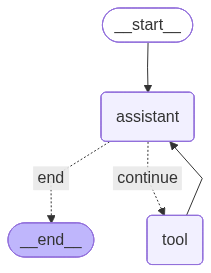

In [3]:
# 创建图
builder = StateGraph(MessagesState)

# 添加节点
builder.add_node('assistant', assistant)
builder.add_node('tool', tool_node)

# 添加边
builder.add_edge(START, 'assistant')

# 添加条件边
builder.add_conditional_edges(
    'assistant',
    should_continue,
    {
        'continue': 'tool',
        'end': END,
    },
)

# 添加边：调用工具节点后回到assistant
builder.add_edge('tool', 'assistant')

# 编译图
my_graph = builder.compile(name='my-graph')
my_graph

> **Note**
>
> 有向图分为：
>
> - 有向无环图（DAG）
> - 有向循环图（DCG）

从可视化结果来看，助手节点 `assistant` 与工具节点 `tool` 之间存在循环调用。因此，我们创建的是 **有向循环图**。下面来看一下，当询问上海天气时，工作流的运行过程。

In [4]:
# 调用图
response = my_graph.invoke({'messages': [HumanMessage(content='上海天气怎么样？')]})
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

上海天气怎么样？
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_64f93aa538c1482abde0b481)
 Call ID: call_64f93aa538c1482abde0b481
  Args:
    city: 上海
================================= Tool Message =================================
Name: get_weather

It's always sunny in 上海!
================================== Ai Message ==================================

上海的天气总是晴朗明媚！气温适宜，非常适合外出活动。如果你在上海，记得享受这美好的阳光哦！
